In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib
import numpy as np
from tensorflow.keras.preprocessing import image
from skimage.io import imread
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,Dropout, Conv2D
from tensorflow.keras import Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [11]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [12]:
def load_image_paths(container_path):
    image_dir = pathlib.Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    image_paths = []
    flat_data = []
    target = []
    count = 0
    train_img_path = []
    train_label = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            train_img_path.append(str(file))
            train_label.append(categories[i])

    X = np.array(train_img_path)
    y = np.array(train_label)
    catStringArr = np.array(categories)

    return X, y, catStringArr


In [13]:
X = []
y = []
X, y, labelStringArr = load_image_paths("/home/pascal_steiger/Downloads/data/")
img_df = pd.DataFrame(zip(X, y), columns=["path", "label"])

print(labelStringArr)

img_df.sample(n=10)

['MKD' 'HRV' 'ISL' 'IRL' 'ITA' 'HUN' 'LVA' 'GBR' 'FRA' 'LTU' 'AUT' 'SVN'
 'FIN' 'ESP' 'NOR' 'BGR' 'PRT' 'SVK' 'BEL' 'EST' 'POL' 'CZE' 'NLD' 'CHE'
 'DNK' 'SWE']


,path,label
7024,/home/pascal_steiger/Downloads/data/GBR/img_51...,GBR
2432,/home/pascal_steiger/Downloads/data/ISL/img_IS...,ISL
8281,/home/pascal_steiger/Downloads/data/FRA/img_43...,FRA
349,/home/pascal_steiger/Downloads/data/MKD/img_MK...,MKD
2356,/home/pascal_steiger/Downloads/data/ISL/img_IS...,ISL
14786,/home/pascal_steiger/Downloads/data/NOR/img_NO...,NOR
23174,/home/pascal_steiger/Downloads/data/NLD/img_51...,NLD
17849,/home/pascal_steiger/Downloads/data/SVK/img_SV...,SVK
7789,/home/pascal_steiger/Downloads/data/GBR/img_53...,GBR
9884,/home/pascal_steiger/Downloads/data/LTU/img_LT...,LTU


In [14]:
train_df, test_df = train_test_split(img_df, shuffle=True, test_size=0.2, random_state=42)


print(train_df.sample(n=5))
print(train_df.shape)
print(test_df.sample(n=5))
print(test_df.shape)


                                                    path label
19010  /home/pascal_steiger/Downloads/data/BEL/img_50...   BEL
1167   /home/pascal_steiger/Downloads/data/HRV/img_HR...   HRV
25442  /home/pascal_steiger/Downloads/data/DNK/img_DN...   DNK
26331  /home/pascal_steiger/Downloads/data/SWE/img_SW...   SWE
6047   /home/pascal_steiger/Downloads/data/LVA/img_LV...   LVA
(21234, 2)
                                                    path label
11585  /home/pascal_steiger/Downloads/data/SVN/img_SV...   SVN
10366  /home/pascal_steiger/Downloads/data/AUT/img_AU...   AUT
12261  /home/pascal_steiger/Downloads/data/FIN/img_FI...   FIN
16820  /home/pascal_steiger/Downloads/data/PRT/img_PR...   PRT
5640   /home/pascal_steiger/Downloads/data/HUN/img_HU...   HUN
(5309, 2)


In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator()

In [16]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="path",
        y_col="label",
        target_size=(380, 380),
        batch_size=32,
        class_mode="sparse",
        seed=42
)


validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="path",
        y_col="label",
        target_size=(380, 380),
        batch_size=32,
        class_mode="sparse",
        shuffle=False
)

Found 21234 validated image filenames belonging to 26 classes.
Found 5309 validated image filenames belonging to 26 classes.


In [29]:
with tf.device("/device:GPU:0"):
    from tensorflow.keras.applications import EfficientNetB4
    tl_efnet = EfficientNetB4(include_top=True,weights="imagenet")
    tl_efnet = tf.keras.Model(tl_efnet.input, tl_efnet.layers[-2].output)
    
    for layer in tl_efnet.layers:
        layer.trainable = False

    for layer in tl_efnet.layers[-5:]:
        layer.trainable = True 
    

In [30]:
tl_efnet.summary()


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling_5 (Rescaling)         (None, 380, 380, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
normalization_5 (Normalization) (None, 380, 380, 3)  7           rescaling_5[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization_5[0][0]            
____________________________________________________________________________________________

In [31]:
with tf.device("/device:GPU:0"):

    I = Input(shape=(380, 380, 3))



    x = tl_efnet(I)



    dense = Dense(1024, activation='relu', name='denserelu')(x)
    
    dropout = Dropout(0.1)(dense)

    dense2 = Dense(512, activation='relu', name='denserelu2')(dropout)
    
    dropout2 = Dropout(0.1)(dense2)

    dense3 = Dense(26, activation='softmax', name='my_dense')(dropout2)

    #prediction = Dense(26, activation='softmax', name='prediction')



    #out2 = prediction(x)


    new_model2 = tf.keras.Model(I, dense3)

    new_model2.summary()





Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 380, 380, 3)]     0         
_________________________________________________________________
model_7 (Functional)         (None, 1792)              17673823  
_________________________________________________________________
denserelu (Dense)            (None, 1024)              1836032   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
denserelu2 (Dense)           (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
my_dense (Dense)             (None, 26)                1333

In [33]:
def unwrap_model(model):
    mdl = model.get_layer('model_7')
    inp = mdl.input
    out = model.get_layer('denserelu')(mdl.output)
    out = model.get_layer('dropout_4')(out)
    out = model.get_layer('denserelu2')(out)
    out = model.get_layer('dropout_5')(out)
    out = model.get_layer('my_dense')(out)
    return tf.keras.Model(inp, out)   
    
new_model2 = unwrap_model(new_model2)

    
new_model2.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling_5 (Rescaling)         (None, 380, 380, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
normalization_5 (Normalization) (None, 380, 380, 3)  7           rescaling_5[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization_5[0][0]            
____________________________________________________________________________________________

In [34]:
# define callbacks for early stopping

early_stopping = EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [35]:
with tf.device("/device:GPU:0"):
    new_model2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

with tf.device("/device:GPU:0"):
    history = new_model2.fit(
          train_generator,
          epochs=200,
          verbose = 1,
          callbacks=callbacks,
          validation_data=validation_generator)
    new_model2.save('CNN-TL_efficientNet.h5')

Epoch 1/200
664/664 [==============================] - 849s 1s/step - loss: 2.5435 - sparse_categorical_accuracy: 0.2432 - val_loss: 2.1755 - val_sparse_categorical_accuracy: 0.3228
Epoch 2/200
664/664 [==============================] - 827s 1s/step - loss: 2.1951 - sparse_categorical_accuracy: 0.3314 - val_loss: 2.0424 - val_sparse_categorical_accuracy: 0.3720
Epoch 3/200
664/664 [==============================] - 827s 1s/step - loss: 2.0474 - sparse_categorical_accuracy: 0.3683 - val_loss: 1.9165 - val_sparse_categorical_accuracy: 0.4059
Epoch 4/200
664/664 [==============================] - 825s 1s/step - loss: 1.9546 - sparse_categorical_accuracy: 0.3980 - val_loss: 1.8606 - val_sparse_categorical_accuracy: 0.4155
Epoch 5/200
664/664 [==============================] - 818s 1s/step - loss: 1.8713 - sparse_categorical_accuracy: 0.4140 - val_loss: 1.8490 - val_sparse_categorical_accuracy: 0.4249
Epoch 6/200
664/664 [==============================] - 825s 1s/step - loss: 1.7972 - spars

Epoch 46/200
664/664 [==============================] - 780s 1s/step - loss: 0.7601 - sparse_categorical_accuracy: 0.7544 - val_loss: 2.0959 - val_sparse_categorical_accuracy: 0.5182
Epoch 47/200
664/664 [==============================] - 779s 1s/step - loss: 0.7490 - sparse_categorical_accuracy: 0.7599 - val_loss: 2.1473 - val_sparse_categorical_accuracy: 0.5101

Epoch 00047: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 48/200
664/664 [==============================] - 780s 1s/step - loss: 0.6513 - sparse_categorical_accuracy: 0.7867 - val_loss: 2.0895 - val_sparse_categorical_accuracy: 0.5291
Epoch 49/200
664/664 [==============================] - 803s 1s/step - loss: 0.5926 - sparse_categorical_accuracy: 0.8073 - val_loss: 2.1342 - val_sparse_categorical_accuracy: 0.5340
Epoch 50/200
664/664 [==============================] - 780s 1s/step - loss: 0.5702 - sparse_categorical_accuracy: 0.8149 - val_loss: 2.1186 - val_sparse_categorical_accuracy: 0.5396
Epoc

Epoch 90/200
664/664 [==============================] - 792s 1s/step - loss: 0.2921 - sparse_categorical_accuracy: 0.9044 - val_loss: 2.4002 - val_sparse_categorical_accuracy: 0.5636
Epoch 91/200
664/664 [==============================] - 781s 1s/step - loss: 0.2933 - sparse_categorical_accuracy: 0.9046 - val_loss: 2.3936 - val_sparse_categorical_accuracy: 0.5587
Epoch 92/200
664/664 [==============================] - 784s 1s/step - loss: 0.2911 - sparse_categorical_accuracy: 0.9055 - val_loss: 2.4240 - val_sparse_categorical_accuracy: 0.5634
Epoch 93/200
664/664 [==============================] - 785s 1s/step - loss: 0.2851 - sparse_categorical_accuracy: 0.9068 - val_loss: 2.3754 - val_sparse_categorical_accuracy: 0.5630
Epoch 94/200
664/664 [==============================] - 785s 1s/step - loss: 0.2825 - sparse_categorical_accuracy: 0.9078 - val_loss: 2.3782 - val_sparse_categorical_accuracy: 0.5621
Epoch 95/200
664/664 [==============================] - 783s 1s/step - loss: 0.2821 -

/home/pascal_steiger/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


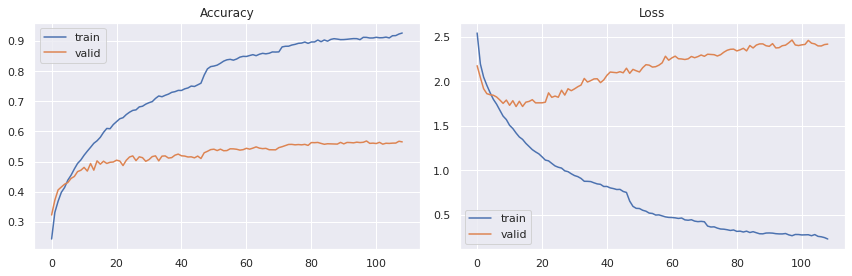

In [36]:
# plot training and validation metrics

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['sparse_categorical_accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_sparse_categorical_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('CNN(380,380)-tl_efficientnet.png')

plt.show()

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
num_of_test_samples=5309
batch_size=32
Y_pred = new_model2.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = sorted(labelStringArr)
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/home/pascal_steiger/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[ 99   3   2   3   7   5   3   2   2   3   0   4   3   1   2   2   2   2
    4   4   8   2   3   9  16   4]
 [  4  75   1   4   5   8   4   3   1  13  17   1   1  11   0   6   1   1
    0  16   2   3   4   3   0   3]
 [  0   0 153   1   3   3   1   0   0   2   0   5   4   2   2   1   0   0
   12   0   0   3   4   4   5   0]
 [ 10   4   2 147   1   0   1   0   2   2   2   1   1   1   1   1   0   1
    3   3   1   0   2   2   2   4]
 [ 12   5   2   2 101   6   3   6   3   5   3   1   9   3   1   2   3   5
    2   4   3  17   1   5   7   6]
 [  5   3   1   1   5 116   0   2   0   3   6   2   2   7   0   4   1   1
    0  10   8   4   1   4   3   7]
 [  5   4   4   2   7   0 171   1   1   9   5   6   0   3   3   5   0   4
   10   0   5   4  38   9  11   0]
 [  3   2   0   1   5   4   1 126   0   6   0   3   2   1   0   1   8  12
    1   2   0   5   0   1   3   1]
 [  1   2   1   0   1   2   0   2 160   2   0   0   2   2   3   2   1   3
    1   2   8   1   0   0   1  19]
 [